# 01. Importing data and libraries 

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = '35X_myRdWj7URTzrLjUG'

In [3]:
# Importing the Inflation Rates on the "Consumer Price INdex - USA" variable. 

data = quandl.get('RATEINF/CPI_USA')

In [4]:
data.head()

,Value
Date,
1913-01-31,9.8
1913-02-28,9.8
1913-03-31,9.8
1913-04-30,9.8
1913-05-31,9.7


In [5]:
data.shape

(1325, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

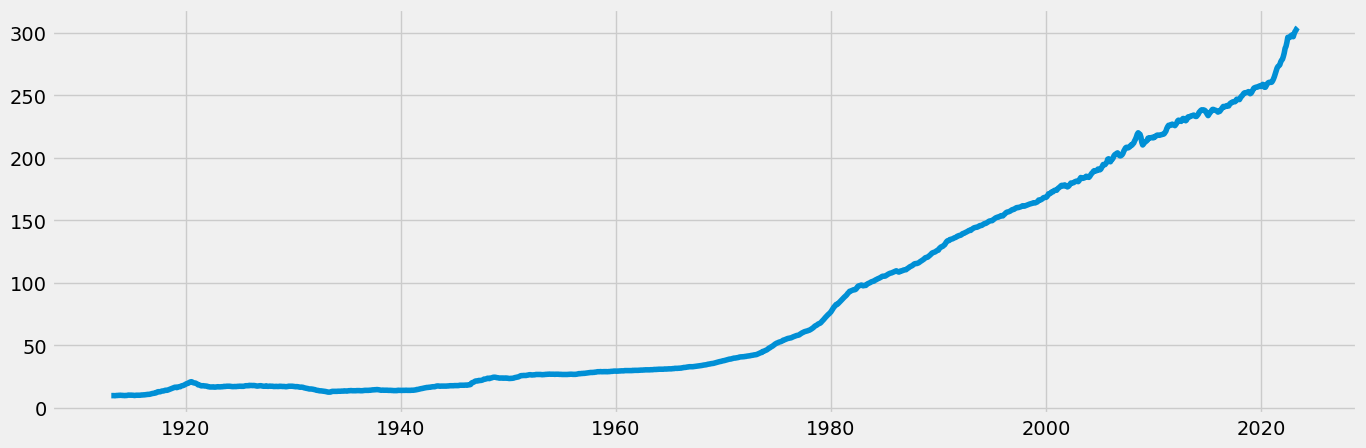

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

# 02. Subsetting, wrangling, and cleaning

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1913-01-31,9.8
1,1913-02-28,9.8
2,1913-03-31,9.8
3,1913-04-30,9.8
4,1913-05-31,9.7


In [11]:
# Create a subset to include only dates after 1980 due to reflect the more current economic status 
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01')]

In [13]:
data_sub.shape

(521, 2)

In [14]:
data_sub.head()

,Date,Value
804,1980-01-31,77.8
805,1980-02-29,78.9
806,1980-03-31,80.1
807,1980-04-30,81.0
808,1980-05-31,81.8


In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-31,77.8
1980-02-29,78.9
1980-03-31,80.1
1980-04-30,81.0
1980-05-31,81.8


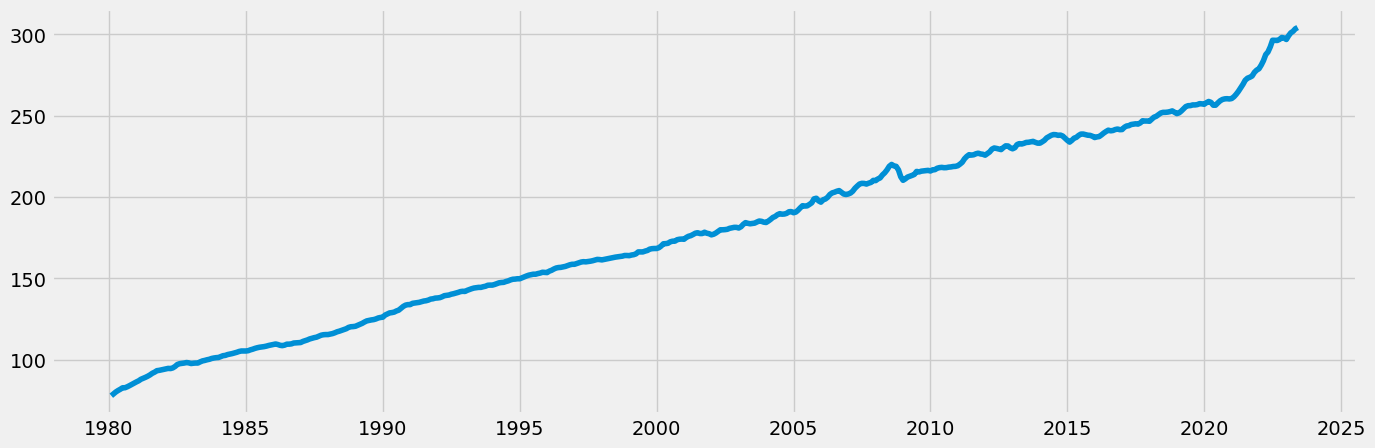

In [16]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [22]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()


29

In [27]:
#Drop duplicate rows
data_sub2 = data_sub.drop_duplicates()

In [28]:
dups2 = data_sub2.duplicated()
dups2.sum()

0

# 03. Time series analysis: decomposition 

In [32]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

This one did not work with the dataframe I made without duplicates, so I will continue to use data_sub even though it does contain some duplicate values. 

In [33]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

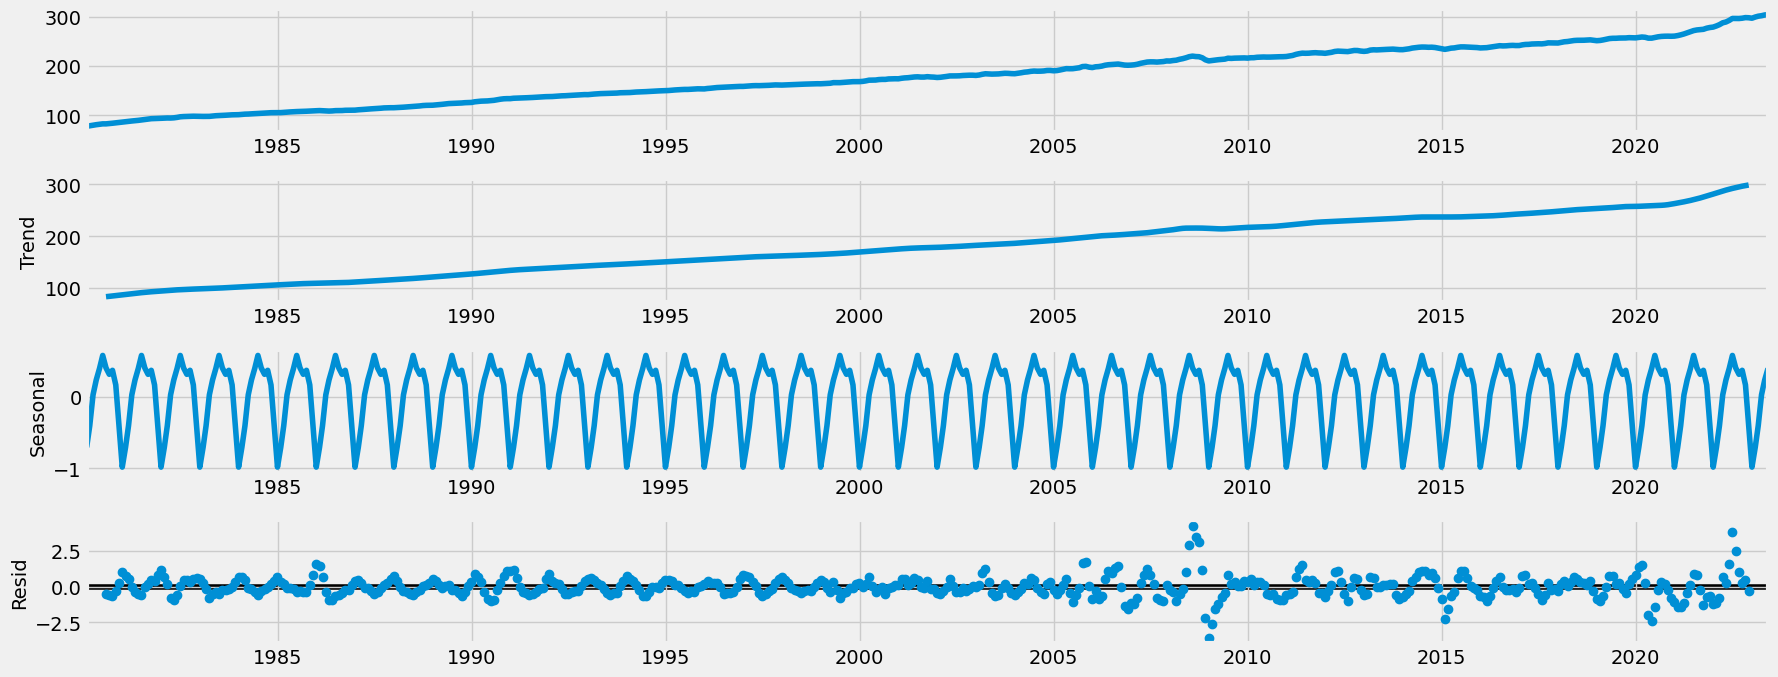

In [34]:
# Plot the separate components

decomposition.plot()
plt.show()

The second line chart shows the underlying trend of the data which in this case is positive. The third component shows the seasonality. The curves on this line chart indicate that there is seasonality in this data. This fourth component is the noise, and in this case there is not much of that. 

# 04. Test for stationarity 

In [35]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.406001
p-value                          0.997141
Number of Lags Used             13.000000
Number of Observations Used    507.000000
Critical Value (1%)             -3.443314
Critical Value (5%)             -2.867258
Critical Value (10%)            -2.569815
dtype: float64


The critical value at 5% is -2.867 which is much smaller than the Test statistic, 0.997. This means that we cannot reject the null hypothesis and our data does contain a unit root, meaning it is non-stationary. 

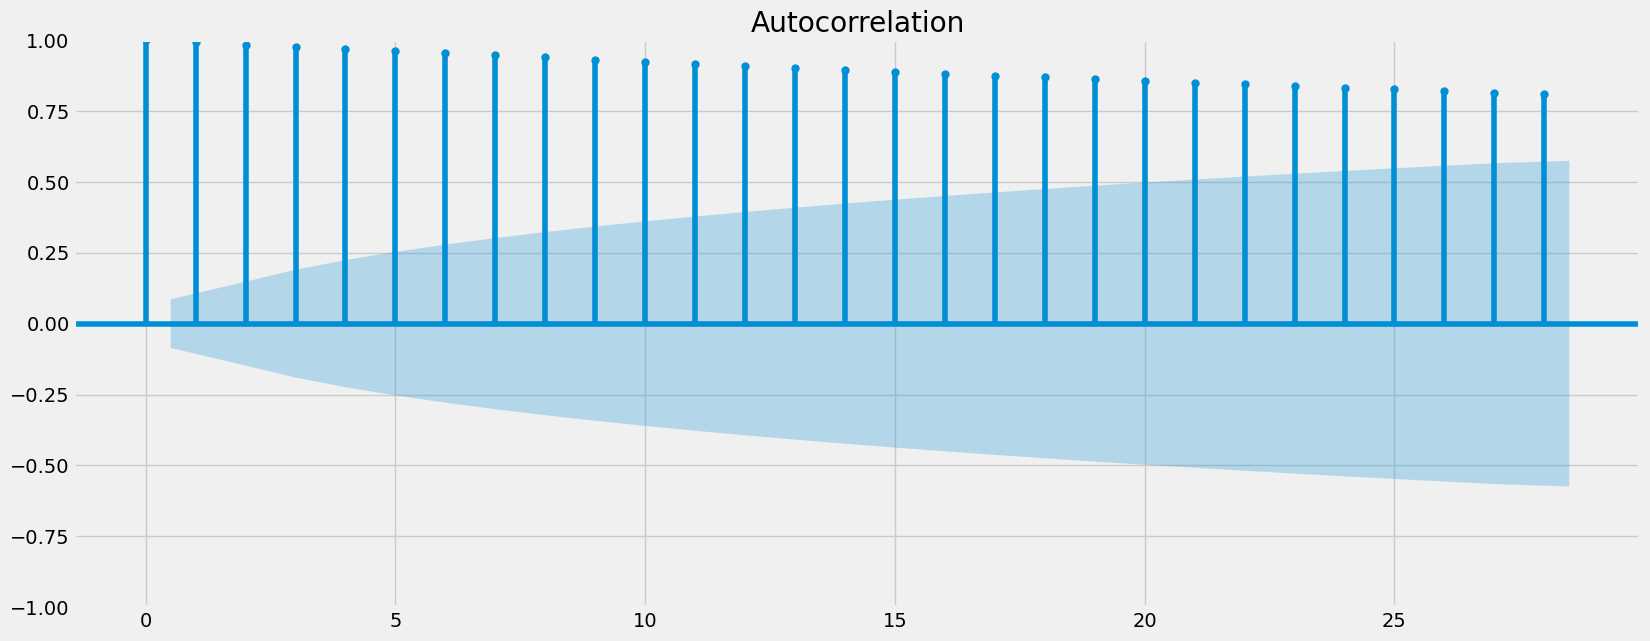

In [36]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

# 05. Stationarizing the data

In [37]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [38]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [39]:
data_diff.head()

,Value
datetime,
1980-02-29,1.1
1980-03-31,1.2
1980-04-30,0.9
1980-05-31,0.8
1980-06-30,0.9


In [40]:
data_diff.columns

Index(['Value'], dtype='object')

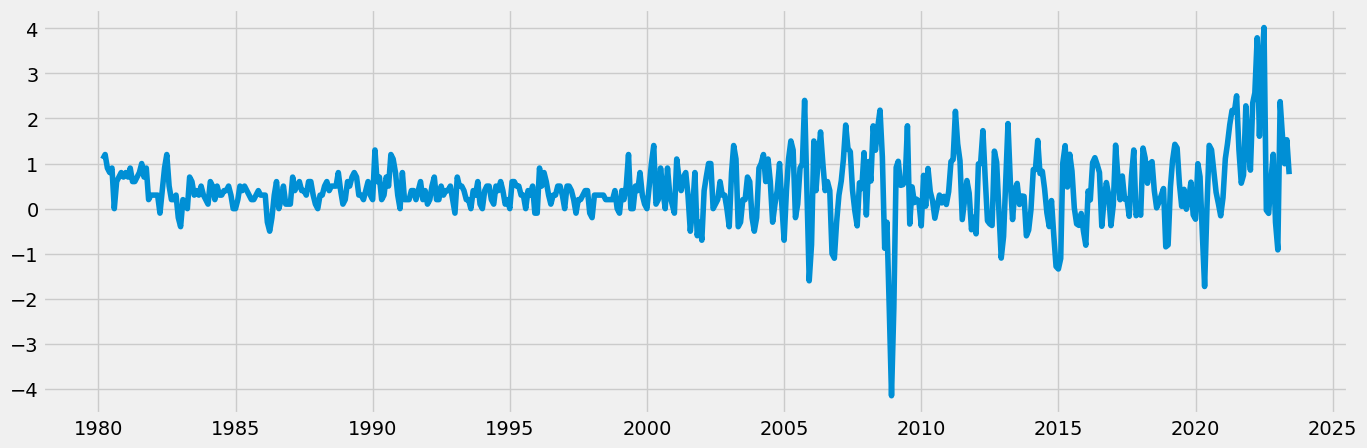

In [41]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [42]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.041560
p-value                          0.001208
Number of Lags Used             12.000000
Number of Observations Used    507.000000
Critical Value (1%)             -3.443314
Critical Value (5%)             -2.867258
Critical Value (10%)            -2.569815
dtype: float64


The test statistic is now lower than the critical value meaning we can reject the null hypothesis and say that our data is staionary.  

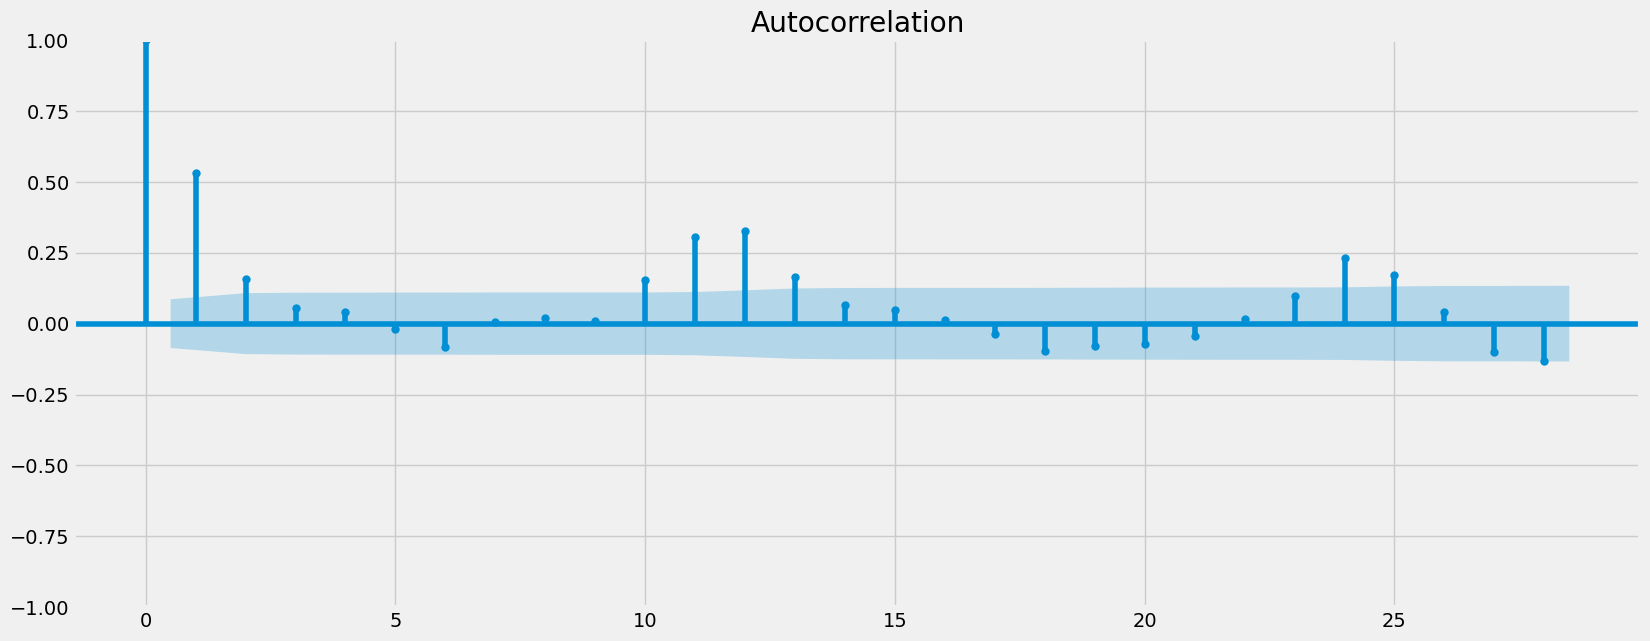

In [43]:
plot_acf(data_diff)
plt.show()